# Kalman smoother for 2-D data

The following demo is provided by courtesy of Kevin Murphy and is based on Sec.18.2.1 of his book (Murphy, 2012; ["Machine Learning - A Probabilistic Perspective"](https://www.cs.ubc.ca/~murphyk/MLbook/)).

We consider the following model with a latent state variable sequence `x` and an observed variable sequence `y`

\begin{align*}
    x_0 &\sim \mathcal{N}(\mu_0, V_0)\\
    x_t &\sim \mathcal{N}(F x_{t-1}, Q)\\
    y_t &\sim \mathcal{N}(H x_t, R)\,.
\end{align*}

We are interested in estimating a posterior belief over the hidden state sequence from an observed data sequence `y=y_hat`.

In [1]:
using ForneyLab
using LinearAlgebra
using Random
import Distributions: pdf, MvNormal, rand

Random.seed!(1) # Set random seed

T = 10 # Number of timepoints

# Generative parameters
mu_0 = [8.0, 10.0, 1.0, 0.0] # Prior mean
V_0 = diageye(4) # Prior covariance; diageye ensures an identity matrix of Diagonal type
F = [1.0 0.0 1.0 0.0; 
     0.0 1.0 0.0 1.0; 
     0.0 0.0 1.0 0.0; 
     0.0 0.0 0.0 1.0] # Process matrix
H = [1.0 0.0 0.0 0.0; 
     0.0 1.0 0.0 0.0] # Observation matrix
Q = 1e-3*diageye(4) # Process noise covariance
R = 1e-1*diageye(2) # Observation noise covariance

# Data
x_hat = Vector{Vector{Float64}}(undef, T)
y_hat = Vector{Vector{Float64}}(undef, T)
prior_x = MvNormal(mu_0, V_0)
process_noise_dist = MvNormal(zeros(4), Q)
obs_noise_dist = MvNormal(zeros(2), R)

x_hat[1] = rand(prior_x)
y_hat[1] = H*x_hat[1] + rand(obs_noise_dist)
for t = 2:T
    x_hat[t] = F*x_hat[t-1] + rand(process_noise_dist) # Execute process
    y_hat[t] = H*x_hat[t] + rand(obs_noise_dist) # Draw observation
end
;

## Model specification

In [2]:
g = FactorGraph()

@RV x0 ~ GaussianMeanVariance(mu_0, V_0) # Prior

x = Vector{Variable}(undef, T) # Pre-define vectors for storing latent and observed variables
y = Vector{Variable}(undef, T)
x_t_prev = x0
for t = 1:T
    @RV x[t] ~ GaussianMeanVariance(F*x_t_prev, Q) # Process model
    @RV y[t] ~ GaussianMeanVariance(H*x[t], R) # Observation model

    placeholder(y[t], :y, dims=(2,), index=t) # Indicate observed variable
    
    x_t_prev = x[t] # Prepare state for next section
end
;

## Algorithm generation

In [3]:
algo = messagePassingAlgorithm(x) # Generate algorithm
source_code = algorithmSourceCode(algo) # Generate source code for algorithm
eval(Meta.parse(source_code)); # Load algorithm

## Algorithm execution

In [4]:
data = Dict(:y => y_hat) # Prepare data dictionary
marginals = step!(data) # Execute inference
;

## Results

In [5]:
using PyPlot

m_x = [mean(marginals[:x_*t]) for t=1:T]
V_x = [cov(marginals[:x_*t]) for t=1:T]
;

In [6]:
# Source: https://github.com/probml/pmtk3/blob/master/matlabTools/graphics/gaussPlot2d.m
function plotGauss2D(m, C)
    U = eigvecs(C)
    D = eigvals(C)
    N = 100
    t = range(0.0, 2*pi, length=N)
    xy = zeros(Float64, 2, N)
    xy[1,:] = cos.(t)
    xy[2,:] = sin.(t)
    k = sqrt(6) # approx sqrt(chi2inv(0.95, 2)) = 2.45
    w = (k * U * Diagonal(sqrt.(D))) * xy # 2*N
    scatter([m[1]], [m[2]], marker="x", color="red")
    plot(w[1,:] .+ m[1], w[2,:] .+ m[2], color="blue")
end;

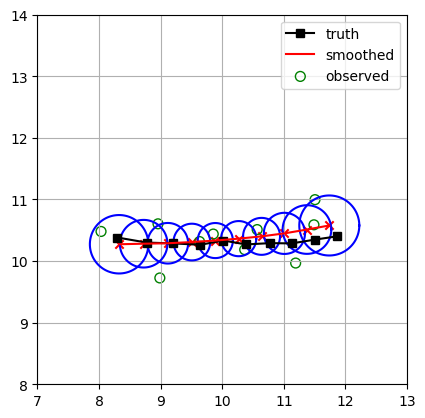

In [7]:
for t=1:T
    plotGauss2D(m_x[t][1:2], V_x[t][1:2,1:2])
end
y_hat_mat = hcat(y_hat...)'
scatter(y_hat_mat[:,1], y_hat_mat[:,2], label="observed", color="green", marker="o", facecolor="none", s=50)
x_hat_mat = hcat(x_hat...)'
plot(x_hat_mat[:,1], x_hat_mat[:,2], color="black", label="truth", marker="s")
m_x_mat = hcat(m_x...)'
plot(m_x_mat[:,1],m_x_mat[:,2], color="red", label="smoothed")
grid("on")
axis("square")
xlim(7,13)
ylim(8,14)
legend()
;